In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')
user = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

In [3]:
print(engagement.head())
print(user.head())

            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1
   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com   

In [4]:
engagement.time_stamp = pd.to_datetime(engagement.time_stamp, format='%Y-%m-%d %H:%M:%S')
engagement['login_date'] = engagement.time_stamp.dt.date
engagement.head()

,time_stamp,user_id,visited,login_date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [5]:
# define a function to decide if a user is an adopted user
def adopted_user(id):
    
    # create a empty DataFrame
    logins = pd.DataFrame()
    
    # login_date is the unique login date in ascending order of the user specified
    logins['login_date'] = engagement.query('user_id == {}'.format(id))['login_date'].unique()
    logins.login_date = logins.login_date.sort_values()
    
    # calculate the number of days between 3 consecutive logins and store in days_btw_3_logins
    try:
        logins['days_btw_3_logins'] = (logins.login_date.shift(-2) - logins.login_date).dt.days
    except AttributeError:
        logins['days_btw_3_logins'] = np.nan
    
    # an adopted user is a user who has logged into the product on three separate
    # days in at least one sevenday period, 
    # which means the user must have a days_btw_3_logins <= 6
    return int(logins.days_btw_3_logins.min()<=6)

In [7]:
# create a column that indicates if a user is adopted_user in user DataFrame
user['adopted_user'] = user.object_id.map(adopted_user)
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [8]:
# Process the data

# convert last_session_creation_time and creation_time to datetime
user['last_session_creation_time'] = pd.to_datetime(user['last_session_creation_time'] ,unit='s')
user['creation_time'] = pd.to_datetime(user['creation_time'], format='%Y-%m-%d %H:%M:%S')

# calculate the day difference between last_session_creation_time and today, creation_time and today
user['days_since_last_session'] = (pd.to_datetime('today') - user['last_session_creation_time']).dt.days
user['days_since_creation'] = (pd.to_datetime('today') - user['creation_time']).dt.days

# extract email domain
user['email_domain'] = user['email'].str.split('@').str[1]

# add a column 'invitation_count': the number of people the user invites
invites = pd.DataFrame(user.invited_by_user_id.value_counts()).reset_index()
invites = invites.rename(columns={'index': 'object_id', 'invited_by_user_id': 'invite_count'})
user = user.join(invites.set_index('object_id'), how='left', on='object_id')
user.invite_count = user.invite_count.fillna(0)
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,days_since_last_session,days_since_creation,email_domain,invite_count
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1984.0,1984,yahoo.com,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2006.0,2142,gustr.com,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,2382.0,2382,gustr.com,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,2319.0,2320,yahoo.com,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,2439.0,2444,yahoo.com,0.0


In [9]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null int64
days_since_last_session       8823 non-null float64
days_since_creation           12000 non-null int64
email_domain                  12000 non-null object
invite_count                  12000 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(6), object(4)
memory usage: 1.4+ MB


In [11]:
# Drop object_id, creation_time, name, email, last_session_creation_time
data_df = pd.DataFrame()
data_df = user.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time'], axis=1)

In [12]:
# fill na with 0 in days_since_last_session and invited_by_user_id
data_df.days_since_last_session = user.days_since_last_session.fillna(0)
data_df.invited_by_user_id = user.invited_by_user_id.fillna(0)

In [19]:
# Mark email_domain as 'Other' if it is not in the main_domains
main_domains = user.email_domain.value_counts().index[0:6]
user['email_domain'] = [x if x in main_domains else 'other' for x in user.email_domain]

In [20]:
# use sklearn.preprocessing.LabelEncoder to engineer categorical labels
from sklearn.preprocessing import LabelEncoder

cat_le = LabelEncoder()
creation_labels = cat_le.fit_transform(user['creation_source'])
data_df.creation_source = creation_labels

org_id_labels = cat_le.fit_transform(user['org_id'])
data_df.org_id = org_id_labels

invited_labels = cat_le.fit_transform(user['invited_by_user_id'])
data_df.invited_by_user_id = invited_labels

email_labels = cat_le.fit_transform(user['email_domain'])
data_df.email_domain = email_labels

data_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,days_since_last_session,days_since_creation,email_domain,invite_count
0,0,1,0,11,2324,0,1984.0,1984,6,0.0
1,1,0,0,1,55,1,2006.0,2142,2,0.0
2,1,0,0,94,297,0,2382.0,2382,2,1.0
3,0,0,0,1,1103,0,2319.0,2320,6,0.0
4,0,0,0,193,1126,0,2439.0,2444,6,0.0


In [23]:
# prepare data for modeling
X = data_df.drop('adopted_user', axis=1)
y = data_df.adopted_user

# split X, y into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8400, 9), (8400,), (3600, 9), (3600,))

In [24]:
# Random Forest Classifier can be used in this case
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
from sklearn.metrics import accuracy_score

y_train_predict = rf.predict(X_train)
acc = accuracy_score(y_train, y_train_predict)
acc

0.9960714285714286

In [28]:
from sklearn.model_selection import cross_val_score

acc_CV = cross_val_score(rf, X_train, y_train, cv=5, scoring="accuracy").mean() 
acc_CV

0.9664285714285714

In [29]:
# check out accuracy on test set
y_test_predict = rf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_predict)
acc_test

0.9661111111111111

In [32]:
rf.feature_importances_

array([0.0387355 , 0.00651192, 0.00464847, 0.0550992 , 0.05608837,
       0.57245202, 0.22821354, 0.02060244, 0.01764854])

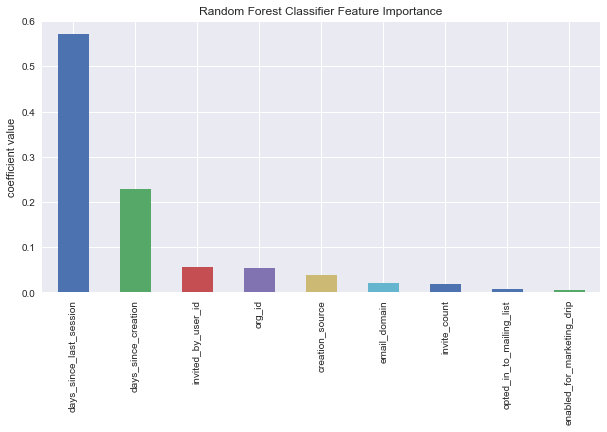

In [38]:
# plot feature importances
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(X_test.columns).sort_values(by='coef', ascending=False)

plt.figure(figsize=(10,5))
(feature_importance['coef']).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

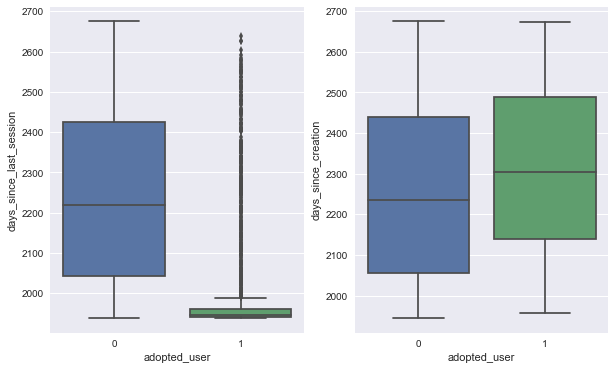

In [44]:
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
sns.boxplot(x=user.adopted_user, y=user.days_since_last_session)

plt.subplot(1, 2, 2)
sns.boxplot(x=user.adopted_user, y=user.days_since_creation)

plt.show()